<a href="https://colab.research.google.com/github/yuki0703-sudo/Research/blob/main/%E3%82%AA%E3%83%96%E3%82%B6%E3%83%BC%E3%83%90%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E5%87%BA%E5%8A%9B%E3%83%95%E3%82%A3%E3%83%BC%E3%83%89%E3%83%90%E3%83%83%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def linestyle_generator():#グラフをプロットするときの線種を決めるジェネレータ
  linestyle=['-','--','-.',':']
  lineID=0
  while True:
    yield linestyle[lineID]
    lineID=(lineID+1)%len(linestyle)

def plot_set(fig_ax,*args):#グラフを整える関数
  fig_ax.set_xlabel(args[0]) #x軸のラベルを一つ目の引数で指定
  fig_ax.set_ylabel(args[1]) #y軸のラベルを二つ目の引数で指定
  fig_ax.grid(ls=':')
  if len(args)==3:
    fig_ax.legend(loc=args[2]) #凡例の位置を３つ目の引数で指定

def bodeplot_set(fig_ax,*args): #ボード線図を整える関数
  #ゲイン線図のグリッドとy軸ラベルの設定
  fig_ax[0].grid(which='both',ls=':')
  fig_ax[0].set_ylabel('Gani[db]')
  #位相線図のグリッドとx軸，y軸ラベルの設定
  fig_ax[1].grid(which='both',ls=':')
  fig_ax[1].set_xlabel('$\omega$[rad/s]')
  fig_ax[1].set_ylabel('Phase[deg]')
  #凡例の表示
  if len(args)>0: #引数が１つ以上：ゲイン線図に表示
    fig_ax[1].legend(loc=args[0])
  if len(args)>1: #引数が２つ以上:位相線図にも表示
    fig_ax[0].legend(loc=args[1])

In [ ]:
!pip install control

     |████████████████████████████████| 357 kB 5.4 MB/s 
  Created wheel for control: filename=control-0.9.1-py2.py3-none-any.whl size=364703 sha256=eae5932eef5eed23a731fc661fecfa4c6a73a0e9e09db7183fd9ddd7086d9361
  Stored in directory: /root/.cache/pip/wheels/b1/50/22/8005107713828997d1af664fbd629c7f935a1b87fc2f4ba6c1
Successfully built control


In [ ]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

A='0 1; -4 5'
B='0; 1'
C='1 0'
D='0'
P=ss(A,B,C,D)

observer_pole=[-15+5j,-15-5j]
L=-acker(P.A.T,P.C.T,observer_pole).T
print(L)
np.linalg.eigvals(P.A+L*P.C)


[[ -35.]
 [-421.]]


array([-15.+5.j, -15.-5.j])

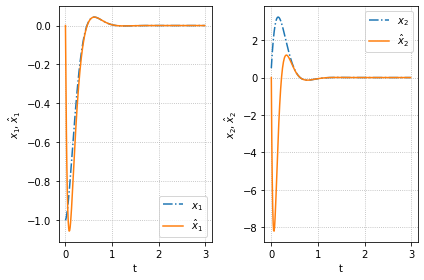

In [ ]:
#オブザーバによる状態推定
fig,ax=plt.subplots(1,2)
Td=np.arange(0,3,0.01)
X0=[-1,0.5]

#制御対象Pを安定化する状態フィードバックゲインの設計
regulator_poles=[-5-5j,-5+5j]
F=-acker(P.A,P.B,regulator_poles)

#真の状態の振る舞い dx/dt=(A+BF)x
Gsf=ss(P.A+P.B*F,P.B,np.eye(2),[[0],[0]])
x,t=initial(Gsf,Td,X0)
ax[0].plot(t,x[:,0],ls='-.',label='${x}_1$')
ax[1].plot(t,x[:,1],ls='-.',label='${x}_2$')

#オブザーバで推定した状態の振る舞い
#入力u=Fx
u=[[F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]#内積
#出力y=Cx
y=x[:,0]
#オブザーバによる状態推定
Obs=ss(P.A+L*P.C,np.c_[P.B, -L],np.eye(2),[[0,0],[0,0]])
xhat,t,_=lsim(Obs,np.c_[u,y],Td,[0,0])
ax[0].plot(t,xhat[:,0],label='$\hat{x}_1$')
ax[1].plot(t,xhat[:,1],label='$\hat{x}_2$')

for i in [0,1]:
  plot_set(ax[i],'t','','best')
ax[0].set_ylabel('$x_1,\hat{x}_1$')
ax[1].set_ylabel('$x_2,\hat{x}_2$')

fig.tight_layout()

K:
 A = [[ -35.    1.]
     [-471.  -10.]]

B = [[ 35.]
     [421.]]

C = [[-46. -15.]]

D = [[0.]]

-------------------
K(s)= 
 -7925 s - 9216
----------------
s^2 + 45 s + 821



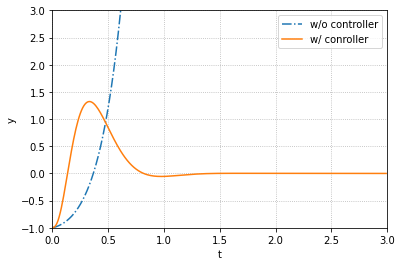

In [ ]:
#出力フィードバック制御器の設計
#状態フィードバックゲインの設計 A+BF
regulator_poles=[-5+5j,-5-5j]
F=-acker(P.A,P.B,regulator_poles)

#オブザーバゲインの設計 A+LC
observer_poles=[-15+5j,-15-5j]
L=-acker(P.A.T,P.C.T,observer_poles).T

#出力フィードバック制御
K=ss(P.A+P.B*F+L*P.C,-L,F,0)
print('K:\n',K)
print('-------------------')
print('K(s)=',tf(K))

#フィードバック制御
Gfb=feedback(P,K,sign=1) #ポジティブフィードバック

fig,ax=plt.subplots()
Td=np.arange(0,3,0.01)
#フィードバック制御なし
y,t=initial(P,Td,[-1,0.5]) #uのみ
ax.plot(t,y,ls='-.',label='w/o controller')
#フィードバック制御あり
y,t=initial(Gfb,Td,[-1,0.5,0,0]) #状態フィードバック+オブザーバを用いた出力フィードバック→入力u,出力yの初期値
ax.plot(t,y,label='w/ conroller')
ax.set_ylim(-1,3)
ax.set_xlim(0,3)

plot_set(ax,'t','y','best')

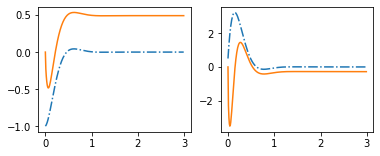

In [ ]:
#定値外乱に対する出力フィードバック制御
fig,ax=plt.subplots(1,2,figsize=(6,2.3))

T=np.arange(0,3,0.01)
X0=[-1,0.5]
d=0.5*(T>0)
#外乱のない状態
x,t=initial(Gsf,T,X0)
ax[0].plot(t,x[:,0],ls='-.',label='${x}_1$')
ax[1].plot(t,x[:,1],ls='-.',label='${x}_2$')

#入力u=Fx
u=[[F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]
#出力y=Cx+d
y=x[:,0]+d
xhat,t,X0=lsim(Obs,np.c_[u,y],T,[0,0])
ax[0].plot(t,xhat[:,0],label='$/hat{x}_1$')
ax[1].plot(t,xhat[:,1],label='$\hat{x]_2$')

#plot_set(ax,'t','x','best')

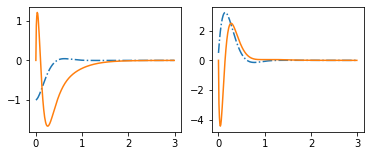

In [ ]:
#定値外乱に対する拡大系出力フィードバック制御
observer_poles=[-15+5j,-15-5j,-3]
#オブザーバゲインは3*3だから，極が3個必要

#外乱オブザーバゲインの設計(拡大系を用いての設計）
E=[[0],[0]]
Abar=np.r_[np.c_[P.A,E],np.zeros((1,3))]
Bbar=np.c_[P.B.T,np.zeros((1,1))].T
Cbar=np.c_[P.C,1]

Lbar=-acker(Abar.T,Cbar.T,observer_poles).T

Aob=Abar+Lbar*Cbar
Bob=np.c_[Bbar,-Lbar]
obs=ss(Aob,Bob,np.eye(3),[[0,0],[0,0],[0,0]])

fig,ax=plt.subplots(1,2,figsize=(6,2.3))

T=np.arange(0,3,0.01)
X0=[-1,0.5]
d=0.5*(T>0) #ステップ上の外乱
x,t=initial(Gsf,T,X0)
ax[0].plot(t,x[:,0],ls='-.',label='${x}_1$')
ax[1].plot(t,x[:,1],ls='-.',label='${x}_2$')

#入力
u=[F[0,0]*x[i,0]+F[0,1]*x[i,1] for i in range(len(x))]
#出力
y=x[:,0]+d
xhat,t,x0=lsim(obs,np.c_[u,y],T,[0,0,0])
ax[0].plot(t,xhat[:,0],label='$\hat{x}_1$')
ax[1].plot(t,xhat[:,1],label='$\hat{x}_2$')